In [1]:
####### ResNet-18 모델 특징 추출
from torch import nn
from torchvision import models


model    = models.resnet18(weights="ResNet18_Weights.IMAGENET1K_V1").eval() # 평가모드
# 레즈넷모델의 마지막 계층을 제외한 모든 계층 추출
features = nn.Sequential(*list(model.children())[:-2])  
# 레즈넷: 입력 줄기(conv1,bn1,relu,maxpool), 네개의 스테이지(layer1,2,3,4), 평균 풀링, FC
# features: 입력 줄기(conv1,bn1,relu,maxpool), 네개의 스테이지(layer1,2,3,4)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /Users/seoyun/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:04<00:00, 9.86MB/s]


In [18]:
####### 특징 맵과 가중치 추출
from PIL import Image
from torchvision import transforms


transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean = [0.485, 0.456, 0.406],
            std  = [0.229, 0.224, 0.225]
        ),
    ]
)

image  = Image.open("../datasets/images/airplane.jpg")
# [C, H, W] -> [배치크기, C, H, W]로 차원추가 + 정규화 및  전처리
target = transform(image).unsqueeze(0) 

# ResNet-18이 판단한 클래스 색인 값
output    = model(target)
class_idx = int(output.argmax())


print(model.fc.weight.shape)
# 해당 클래스 색인에 해당하는 fc 가중치 추출
weights         = model.fc.weight[class_idx].reshape(-1, 1, 1)
# ResNet-18의 마지막 컨볼루션 레이어까지 실행한 결과 반환 (최종 특징 맵)
# squeeze(): 차원 크기가 1인 모든 차원 제거 [1,C,H,W]->[C,H,W]
features_output = features(target).squeeze()

print(weights.shape)
print(features_output.shape)

torch.Size([1000, 512])
torch.Size([512, 1, 1])
torch.Size([512, 7, 7])


In [17]:
####### 클래스 활성화 맵 생성
import torch
from torch.nn import functional as F


# 가중치 적용: 각 특징 맵이 해당 클래스에 대한 영향력 계산(요소별 곱셈)
cam = features_output * weights # [512,7,7]
# 전역 평균 풀링: 각 특징 맵의 채널들을 합치는 작업
cam = torch.sum(cam, dim=0)     # [7,7]

# 입력이미지와 크기 동일한 크기로 변경 (비교하기 위해)
# 원본 이미지 크기로 업/다운샘플링
cam = F.interpolate(
    # 업샘플링할 텐서: cam을 4차원 텐서로 변환 ([1,1,H,W])
    input = cam.unsqueeze(0).unsqueeze(0),
    # size(출력텐서의 공간크기) : (높이, 너비)로 지정
    size  = (image.size[1], image.size[0]),
    # 양성형 보간 사용
    mode  = "bilinear",
).squeeze().detach().numpy()    # [175, 320]
# squeeze로 불필요한 차원 제거 [1,1,H,W]->[H,W]

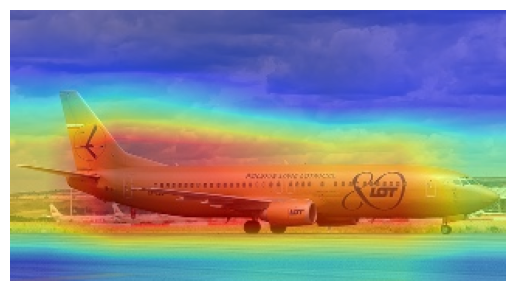

In [4]:
####### 클래스 활성화 맵 시각화
import matplotlib.pyplot as plt


plt.imshow(image)
# jet: 영향 많이 주는 부분-붉은색 <-> 영향 적은 부분-파란색
plt.imshow(cam, cmap="jet", alpha=0.5)
plt.axis("off")
plt.show()